<font size = 5> Mapping mesoscopic phase evolution during e-beam induced transformations via deep learning of atomically resolved images</font>

<p>
R. K. Vasudevan<sup>1,2,*</sup>, N. Laanait<sup>3</sup>, K. Wang<sup>1,2</sup>, D. Geoghegan<sup>1,2</sup>, K. Xiao<sup>1,2</sup>, M. Ziatdinov<sup>1,2</sup>, S. Jesse<sup>1,2</sup>, O. Dyck<sup>1,2</sup> and S. V. Kalinin<sup>1,2</sup> 

*vasudevanrk[at]ornl.gov

<sup>1</sup>Center for Nanophase Materials Sciences, <sup>2</sup>Institute for Functional Imaging of Materials, <sup>3</sup>Computational Sciences and Engineering Division, Oak Ridge National Laboratory, Oak Ridge TN, 37831, USA
</p>

<font color = "blue">In this paper, we demonstrate a deep convolutional neural network for classification of 2D atomically resolved images into one of the five possible Bravais lattice classes</font>.

Below, we provide the trained model and an example of how to use it for a particular image. 
<font color = "red">Packages required to run this notebook are: scipy, numpy, keras, scikit-image and matplotlib.</font>

In [12]:
#Import statements
from os import path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import fftpack, ndimage
from keras.models import load_model
import keras.backend as K
from skimage import color
from skimage.transform import resize

In [13]:
#Define some convenience functions

def predict_with_uncertainty(f, x, n_iter=1000):
    """
    Given a Keras model with dropout layers, this function allows to compute 
    the probabilities of the classification of data x 
    by running the data n_iter times through the network
    with dropout enabled. Function returns the probability and standard deviation for each class.
    More details are available in the paper Gal, Y., & Ghahramani, Z. (2016, June),
    "Dropout as a Bayesian approximation: Representing model uncertainty in deep learning." 
    in international conference on machine learning (pp. 1050-1059).

    Parameters
    ----------
    f : Keras function
        Keras function with f set to be in learning phase (enabling dropout to be used during testing)
    x : numpy array
        Input data of size expected by the Keras model input layer
    n_iter: integer (default, 1000)
        number of passes through the network used to calculate the probability. 

    Returns
    -------
    probability : 1D numpy vector
        1D numpy vector of size given by number of classes in the Keras model, 
        containing the probability of classification of each class.
        
    variance : 1D numpy vector
        1D numpy vector of size given by number of classes in the Keras model, 
        containing the standard deviation of classification of each class.
    """
    result = np.zeros((n_iter,x.shape[0], int(f.outputs[0].shape[1])))
    
    for iter in range(n_iter):
        result[iter,:,:] = np.squeeze(f([x, 1]))
    
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty

def plot_image_with_prob(img, fft_image, prob_list, prob_std, class_labels):
    """
    Convenence function for plotting. Given an image, its fft, 
    and list of probabilities and variances associated with each class,
    plot them side by side in the same manner as in the manuscript (e..g, Fig. 5)

    Parameters
    ----------
    img : 2D numpy array
        Real-space image investigated
    fft_img : 2D numpy array
        2D FFT image to be plotted
    prob_list: 2D numpy array 
        Array of size (nx2), where n is the number of classes as defined in the class dictionary
    class_dict: list
        List containing names of the classes
    
    Returns
    -------
   fig101: matplotlib figure handle
       handle to the figure plotted
    """
    
    width = 0.35  #width of bars in bar chart
    fig, ax = plt.subplots(figsize = (16,6), nrows=1, ncols=3)

    ax[0].imshow(img, cmap = plt.cm.viridis)
    ax[0].set_title('Raw Image')
    ax[0].axis('off')
    ax[1].imshow(fft_image, cmap = plt.cm.viridis)
    ax[1].set_title('FFT Image')
    ax[1].axis('off')

    rects1 = ax[2].bar(np.arange(0,np.max(prob_list.shape)), prob_list.ravel(),
                       width, color='teal', 
                       yerr=prob_std.ravel(), capsize = 8)

    ax[2].set_xticks([0,1,2,3,4,5])
    ax[2].set_xticklabels(class_labels, fontsize = 14)
    ax[2].set_ylim([0,1])
    ax[2].set_yticks([0.2,0.4,0.6, 0.8, 1.0]);
    ax[2].set_yticklabels([0.2,0.4,0.6, 0.8, 1.0], fontsize = 14);
    ax[2].set_title('Prediction Probabilities with St. Dev.', fontsize = 16)
    fig.tight_layout()
    
    return fig

def ZoomInterpol(FFT_image, zoom_factor=1, interpol_factor=1):
    """Given a  2D FFT , return a 2D FFT with a zoom factor and interpolation if desired
    Parameters
    ----------
    FFT_image : 2D numpy array
        Numpy matrix of size (m,m). 2D FFT.
    zoom_factor: integer 
        (optional, default=1). Factor by which to magnify the FFT.
    interpol_factor: integer (optional, default = 1). Factor by which to increase the size of the image by interpolation.
        Array of size (nx2), where n is the number of classes as defined in the class dictionary

    Returns
    -------

    2D Numpy array 
        Numpy array that has been zoomed and inteprolated by the requested amounts.

    """

    zoom_size = (FFT_image.shape[0] / zoom_factor) / 2
    window_size_x = FFT_image.shape[0]
    window_size_y = FFT_image.shape[1]

    if np.mod(FFT_image.shape[0] / zoom_factor, 2) == 0:
        F2_zoomed = FFT_image[int(window_size_x / 2 - zoom_size):int(window_size_x / 2 + zoom_size),
                    int(window_size_y / 2 - zoom_size):int(window_size_y / 2 + zoom_size)]
    else:
        F2_zoomed = FFT_image[int(window_size_x / 2 - zoom_size):int(window_size_x / 2 + 1 + zoom_size),
                    int(window_size_y / 2 - zoom_size):int(window_size_y / 2 + 1 + zoom_size)]

    return ndimage.zoom(F2_zoomed, interpol_factor)

## Load the Trained DCNN Model

In [14]:
#Load the Keras Model
model_folder_path = r'./Model'
model_filename = 'BL_DCNN_64x64_v3.h5'

model = load_model(path.join(model_folder_path, model_filename))
print('Model Loaded from file')

#Turn the model into the learning phase to allow for uncertainty quantification via dropout
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output]) 

#Get model input size
input_size = [model.get_config()[0]['config']['batch_input_shape'][1], 
              model.get_config()[0]['config']['batch_input_shape'][2]]

Model Loaded from file


## Load an example image. In this case, STM image of graphene.

In [15]:
#Class Labels
labels_list = ['cent rect','hex', 'noise', 'rect', 'rhomb', 'square']

#Load an example image
image_folder = r'./STM Images'
STM_image = r'graphene_STM.tif' #replace with your own if you wish to try on your images..

graphene_img = color.rgb2gray(mpimg.imread(path.join(image_folder, STM_image)))

#The network only accepts square images. So let's crop
graphene_img_cropped = graphene_img.copy()[:min(graphene_img.shape), :min(graphene_img.shape)]

#Now take the FFT of the image
g1 = fftpack.fft2((graphene_img_cropped))
g2 = np.abs((fftpack.fftshift((g1))))
g3 = ZoomInterpol(g2, zoom_factor = 4, interpol_factor=4) #Zoom in to see the FFT more clearly.
g3_resized = (resize(np.abs(g3), input_size, order = 3, mode='constant')) #Resize to same shape as expected by DCNN
g3_norm = (g3_resized - np.min(g3_resized)) / (np.max(g3_resized) - np.min(g3_resized)) #Normalize the image intensity

## Run through the DCNN for classification

You may change the n_iter value to larger numbers (e.g., 1E5) to obtain a better estimate of the standard deviation, but this will take substantially longer.

In [16]:
predicted_lat, pred_std = predict_with_uncertainty(f, (g3_norm[None,:,:,None]), n_iter=5000)

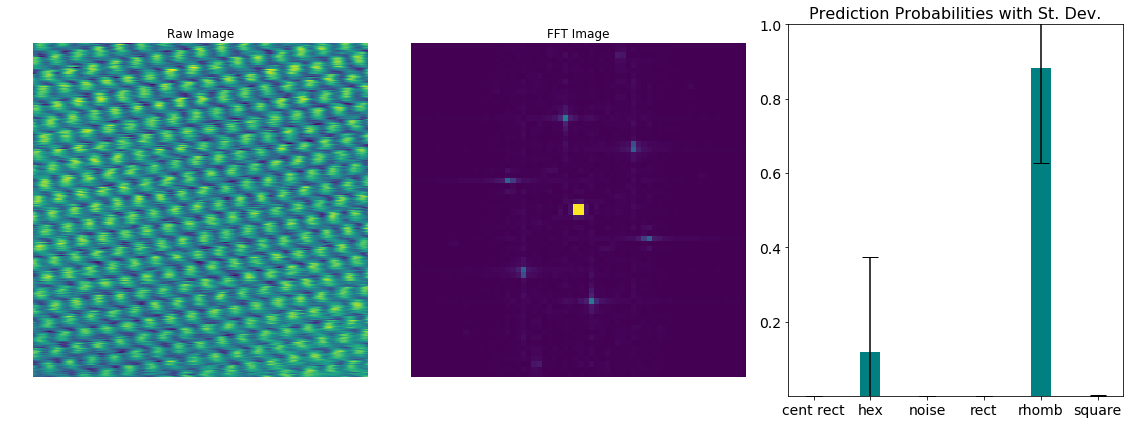

In [17]:
#Plot the results

%matplotlib inline
fig101 = plot_image_with_prob(graphene_img_cropped, g3_norm, predicted_lat, pred_std, labels_list)

  